In [254]:
import os
import random
import sys
import torch

## Package
import glob 
import keras
import IPython.display as ipd
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objs as go
import plotly.offline as py
import plotly.tools as tls
import seaborn as sns
import scipy.io.wavfile
import tensorflow as tf
py.init_notebook_mode(connected=True)


## Keras
from keras import regularizers
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from keras.callbacks import  History, ReduceLROnPlateau, CSVLogger
from keras.models import Model, Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.utils import np_utils
from keras.utils import to_categorical


## Sklearn
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder


## Rest
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
from tqdm import tqdm

input_duration=3

In [255]:
dir_list = os.listdir('C:\\Users\\satyam\\content\\')
dir_list.sort()
print (dir_list)

['Actor_01', 'Actor_02', 'Actor_03', 'Actor_04', 'Actor_05', 'Actor_06', 'Actor_07', 'Actor_08', 'Actor_09', 'Actor_10', 'Actor_11', 'Actor_12', 'Actor_13', 'Actor_14', 'Actor_15', 'Actor_16', 'Actor_17', 'Actor_18', 'Actor_19', 'Actor_20', 'Actor_21', 'Actor_22', 'Actor_23', 'Actor_24']


In [256]:
data_df = pd.DataFrame(columns=['path', 'source', 'actor', 'gender',
                                'intensity', 'statement', 'repetition', 'emotion'])
count = 0
for i in dir_list:
    file_list = os.listdir('C:\\Users\\satyam\\content\\' + i)
    for f in file_list:
        nm = f.split('.')[0].split('-')
        path = 'C:\\Users\\satyam\\content\\' + i + '/' + f
        src = int(nm[1])
        actor = int(nm[-1])
        emotion = int(nm[2])
        
        if int(actor)%2 == 0:
            gender = "female"
        else:
            gender = "male"
        
        if nm[3] == '01':
            intensity = 0
        else:
            intensity = 1
        
        if nm[4] == '01':
            statement = 0
        else:
            statement = 1
        
        if nm[5] == '01':
            repeat = 0
        else:
            repeat = 1
            
        data_df.loc[count] = [path, src, actor, gender, intensity, statement, repeat, emotion]
        count += 1
print (len(data_df))
data_df.head()

1440


,path,source,actor,gender,intensity,statement,repetition,emotion
0,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,0,1
1,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,1,1
2,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,0,1
3,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,1,1
4,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2


In [257]:
filename = data_df.path[1021]
print (filename)

samples, sample_rate = librosa.load(filename)
sample_rate, samples

C:\Users\satyam\content\Actor_18/03-01-01-01-01-02-18.wav


(22050, array([0., 0., 0., ..., 0., 0., 0.], dtype=float32))

In [258]:
len(samples), sample_rate

(77989, 22050)

In [259]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)
sample_rate/ len(samples)

0.28273218017925605

In [260]:
mean = np.mean(spectrogram, axis=0)
std = np.std(spectrogram, axis=0)
spectrogram = (spectrogram - mean) / std
# Trim the silence voice
aa , bb = librosa.effects.trim(samples, top_db=30)
aa, bb

(array([ 1.9985920e-07, -9.0237984e-07,  2.5921154e-06, ...,
         5.4710963e-05,  2.2816404e-05,  1.9574939e-06], dtype=float32),
 array([20992, 58880]))

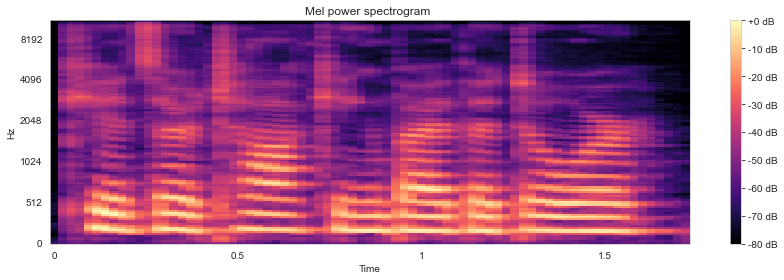

In [261]:
S = librosa.feature.melspectrogram(aa, sr=sample_rate, n_mels=128)

# Convert to log scale (dB). We'll use the peak power (max) as reference.
log_S = librosa.power_to_db(S, ref=np.max)

plt.figure(figsize=(12, 4))
librosa.display.specshow(log_S, sr=sample_rate, x_axis='time', y_axis='mel')
plt.title('Mel power spectrogram ')
plt.colorbar(format='%+02.0f dB')
plt.tight_layout()

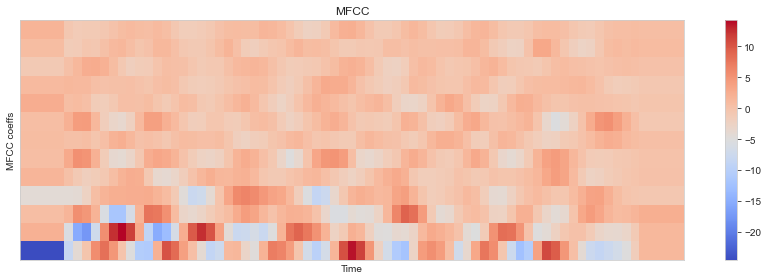

In [262]:
# Plotting MFCC
mfcc = librosa.feature.mfcc(S=log_S, n_mfcc=13)

# Let's pad on the first and second deltas while we're at it
delta2_mfcc = librosa.feature.delta(mfcc, order=2)

plt.figure(figsize=(12, 4))
librosa.display.specshow(delta2_mfcc)
plt.ylabel('MFCC coeffs')
plt.xlabel('Time')
plt.title('MFCC')
plt.colorbar()
plt.tight_layout()

In [263]:
# Original Sound
ipd.Audio(samples, rate=sample_rate)

In [264]:
ipd.Audio(aa, rate=sample_rate)

In [265]:
samples_cut = samples[10000:-12500]
ipd.Audio(samples_cut, rate=sample_rate)

In [266]:
label2_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2: # Calm
        lb = "_positive"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
        
    # Add gender to the label    
    label2_list.append(data_df.gender[i] + lb)
    
len(label2_list)

1440

In [267]:
label3_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1: # Neutral
        lb = "_neutral"
    elif data_df.emotion[i] == 2: # Calm
        lb = "_neutral"
    elif data_df.emotion[i] == 3: # Happy
        lb = "_positive"
    elif data_df.emotion[i] == 4: # Sad
        lb = "_negative"
    elif data_df.emotion[i] == 5: # Angry
        lb = "_negative"
    elif data_df.emotion[i] == 6: # Fearful
        lb = "_negative"
    else:
        lb = "_none"
    
    # Add gender to the label  
    label3_list.append(data_df.gender[i] + lb)
    
len(label3_list)

1440

In [268]:
label5_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"    
    else:
        lb = "_none"
    
    # Add gender to the label  
    label5_list.append(data_df.gender[i] + lb)
    
len(label5_list)

1440

In [295]:
label8_list = []
for i in range(len(data_df)):
    if data_df.emotion[i] == 1:
        lb = "_neutral"
    elif data_df.emotion[i] == 2:
        lb = "_calm"
    elif data_df.emotion[i] == 3:
        lb = "_happy"
    elif data_df.emotion[i] == 4:
        lb = "_sad"
    elif data_df.emotion[i] == 5:
        lb = "_angry"
    elif data_df.emotion[i] == 6:
        lb = "_fearful"
    elif data_df.emotion[i] == 7:
        lb = "_disgust"
    elif data_df.emotion[i] == 8:
        lb = "_surprised"
    else:
        lb = "_none"
        
    # Add gender to the label 
    label8_list.append(data_df.gender[i]  + lb)
    
len(label8_list)

1440

In [296]:
# Select the label set you want by commenting the unwanteds.

data_df['label'] = label2_list
# data_df['label'] = label3_list
# data_df['label'] = label5_list
# data_df['label'] = label8_list
data_df.head()

,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,0,1,male_none
1,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,0,1,1,male_none
2,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,0,1,male_none
3,C:\Users\satyam\content\Actor_01/03-01-01-01-0...,1,1,male,0,1,1,1,male_none
4,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2,male_positive


In [297]:
data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"]
data2_df = data2_df[data2_df.label != "male_happy"]
data2_df = data2_df[data2_df.label != "male_angry"]
data2_df = data2_df[data2_df.label != "male_sad"]
data2_df = data2_df[data2_df.label != "male_fearful"]
data2_df = data2_df[data2_df.label != "male_calm"]
data2_df = data2_df[data2_df.label != "male_positive"]
data2_df = data2_df[data2_df.label != "male_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 22]
tmp2 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp2],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,0,0,2,female_positive
1,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,0,1,2,female_positive
2,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,1,0,2,female_positive
3,C:\Users\satyam\content\Actor_02/03-01-02-01-0...,1,2,female,0,1,1,2,female_positive
4,C:\Users\satyam\content\Actor_02/03-01-02-02-0...,1,2,female,1,0,0,2,female_positive


In [298]:

data2_df = data_df.copy()
data2_df = data2_df[data2_df.label != "male_none"]
data2_df = data2_df[data2_df.label != "female_none"].reset_index(drop=True)
data2_df = data2_df[data2_df.label != "female_neutral"]
data2_df = data2_df[data2_df.label != "female_happy"]
data2_df = data2_df[data2_df.label != "female_angry"]
data2_df = data2_df[data2_df.label != "female_sad"]
data2_df = data2_df[data2_df.label != "female_fearful"]
data2_df = data2_df[data2_df.label != "female_calm"]
data2_df = data2_df[data2_df.label != "female_positive"]
data2_df = data2_df[data2_df.label != "female_negative"].reset_index(drop=True)

tmp1 = data2_df[data2_df.actor == 21]
tmp2 = data2_df[data2_df.actor == 22]
tmp3 = data2_df[data2_df.actor == 23]
tmp4 = data2_df[data2_df.actor == 24]
data3_df = pd.concat([tmp1, tmp3],ignore_index=True).reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 21]
data2_df = data2_df[data2_df.actor != 22]
data2_df = data2_df[data2_df.actor != 23].reset_index(drop=True)
data2_df = data2_df[data2_df.actor != 24].reset_index(drop=True)
print (len(data2_df))
data2_df.head()

400


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,0,2,male_positive
1,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,0,1,2,male_positive
2,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,1,0,2,male_positive
3,C:\Users\satyam\content\Actor_01/03-01-02-01-0...,1,1,male,0,1,1,2,male_positive
4,C:\Users\satyam\content\Actor_01/03-01-02-02-0...,1,1,male,1,0,0,2,male_positive


In [299]:
print (len(data3_df))
data3_df.head()

80


,path,source,actor,gender,intensity,statement,repetition,emotion,label
0,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,0,0,2,male_positive
1,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,0,1,2,male_positive
2,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,1,0,2,male_positive
3,C:\Users\satyam\content\Actor_21/03-01-02-01-0...,1,21,male,0,1,1,2,male_positive
4,C:\Users\satyam\content\Actor_21/03-01-02-02-0...,1,21,male,1,0,0,2,male_positive


In [300]:
data = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data.loc[i] = [feature]

100%|██████████| 400/400 [00:15<00:00, 25.43it/s]


In [301]:
df3 = pd.DataFrame(data['feature'].values.tolist())
labels = data2_df.label
df3.head()

,0,1,2,3,4,5,6,7,8,9,...,249,250,251,252,253,254,255,256,257,258
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-65.447311,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858


In [302]:
newdf = pd.concat([df3,labels], axis=1)
rnewdf = newdf.rename(index=str, columns={"0": "label"})
len(rnewdf)

400

In [303]:
rnewdf.head(10)

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,NaN,NaN,NaN,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive
5,-69.243607,-69.243607,-69.243607,-69.243607,-68.902374,-67.983444,-68.089653,-67.897789,-65.258499,-67.171410,...,-57.186440,-61.189224,-67.108902,-67.508621,-66.246048,-68.733475,-69.243607,-69.243607,-69.243607,male_positive
6,-73.255318,-73.255318,-73.255318,-73.255318,-68.774933,-69.380905,-73.255318,-73.255318,-73.255318,-73.255318,...,-50.886692,-55.668213,-54.602642,-53.441689,-56.299820,-57.457932,-58.767605,-59.844345,-59.074680,male_positive
7,-70.746674,-70.746674,-70.025597,-69.131645,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,-70.746674,...,-70.746674,-70.746674,-70.079544,-69.590736,-69.203033,-70.159676,-70.445572,-68.199638,-67.593987,male_positive
8,-63.787254,-63.128746,-63.412743,-63.797016,-63.582291,-58.921696,-57.955513,-61.225422,-63.783241,-63.797016,...,-63.740913,-62.410637,-62.489479,-62.494827,-62.633003,-62.878506,NaN,NaN,NaN,male_positive
9,-60.981300,-60.116249,-60.978966,-60.952496,-60.982536,-60.983990,-60.981300,-60.981300,-60.981300,-60.249794,...,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,-60.981300,NaN,NaN,NaN,male_positive


In [304]:
rnewdf.isnull().sum().sum()

2284

In [305]:
rnewdf = rnewdf.fillna(0)
rnewdf.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


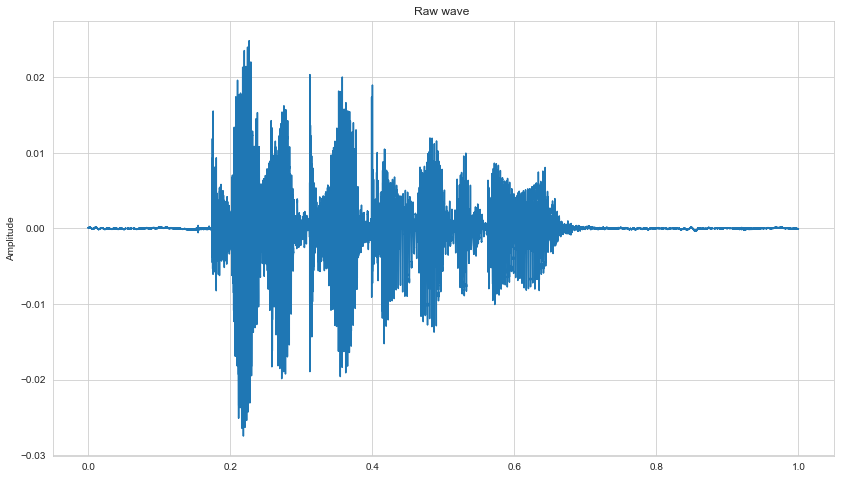

In [306]:
def plot_time_series(data):
    """
    Plot the Audio Frequency.
    """
    fig = plt.figure(figsize=(14, 8))
    plt.title('Raw wave ')
    plt.ylabel('Amplitude')
    plt.plot(np.linspace(0, 1, len(data)), data)
    plt.show()


def noise(data):
    """
    Adding White Noise.
    """
    # you can take any distribution from https://docs.scipy.org/doc/numpy-1.13.0/reference/routines.random.html
    noise_amp = 0.005*np.random.uniform()*np.amax(data)
    data = data.astype('float64') + noise_amp * np.random.normal(size=data.shape[0])
    return data
    
def shift(data):
    """
    Random Shifting.
    """
    s_range = int(np.random.uniform(low=-5, high = 5)*500)
    return np.roll(data, s_range)
    
def stretch(data, rate=0.8):
    """
    Streching the Sound.
    """
    data = librosa.effects.time_stretch(data, rate)
    return data
    
def pitch(data, sample_rate):
    """
    Pitch Tuning.
    """
    bins_per_octave = 12
    pitch_pm = 2
    pitch_change =  pitch_pm * 2*(np.random.uniform())   
    data = librosa.effects.pitch_shift(data.astype('float64'), 
                                      sample_rate, n_steps=pitch_change, 
                                      bins_per_octave=bins_per_octave)
    return data
    
def dyn_change(data):
    """
    Random Value Change.
    """
    dyn_change = np.random.uniform(low=1.5,high=3)
    return (data * dyn_change)
    
def speedNpitch(data):
    """
    peed and Pitch Tuning.
    """
    # you can change low and high here
    length_change = np.random.uniform(low=0.8, high = 1)
    speed_fac = 1.0  / length_change
    tmp = np.interp(np.arange(0,len(data),speed_fac),np.arange(0,len(data)),data)
    minlen = min(data.shape[0], tmp.shape[0])
    data *= 0
    data[0:minlen] = tmp[0:minlen]
    return data
X, sample_rate = librosa.load(data2_df.path[216], res_type='kaiser_fast',duration=4,sr=22050*2,offset=0.5)
plot_time_series(X)
ipd.Audio(X, rate=sample_rate)

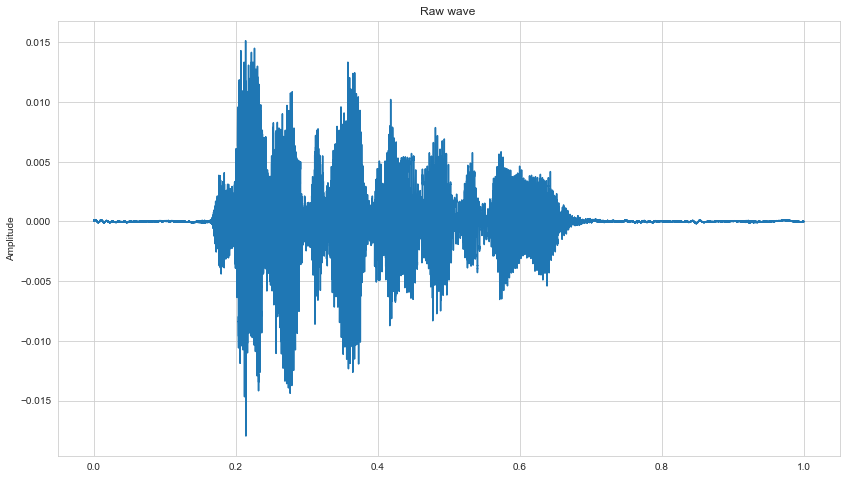

In [307]:
x = pitch(X, sample_rate)
plot_time_series(x)
ipd.Audio(x, rate=sample_rate)

In [308]:
syn_data1 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = noise(X)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data1.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [00:19<00:00, 20.50it/s]


In [309]:
# Augmentation Method 2

syn_data2 = pd.DataFrame(columns=['feature', 'label'])
for i in tqdm(range(len(data2_df))):
    X, sample_rate = librosa.load(data2_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
    if data2_df.label[i]:
#     if data2_df.label[i] == "male_positive":
        X = pitch(X, sample_rate)
        sample_rate = np.array(sample_rate)
        mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
        feature = mfccs
        a = random.uniform(0, 1)
        syn_data2.loc[i] = [feature, data2_df.label[i]]

100%|██████████| 400/400 [01:42<00:00,  3.89it/s]


In [310]:
len(syn_data1), len(syn_data2) 

(400, 400)

In [311]:
syn_data1 = syn_data1.reset_index(drop=True)
syn_data2 = syn_data2.reset_index(drop=True)
df4 = pd.DataFrame(syn_data1['feature'].values.tolist())
labels4 = syn_data1.label
syndf1 = pd.concat([df4,labels4], axis=1)
syndf1 = syndf1.rename(index=str, columns={"0": "label"})
syndf1 = syndf1.fillna(0)
len(syndf1)

400

In [312]:
df4 = pd.DataFrame(syn_data2['feature'].values.tolist())
labels4 = syn_data2.label
syndf2 = pd.concat([df4,labels4], axis=1)
syndf2 = syndf2.rename(index=str, columns={"0": "label"})
syndf2 = syndf2.fillna(0)
len(syndf2)

400

In [313]:
# Combining the Augmented data with original
combined_df = pd.concat([rnewdf, syndf1, syndf2], ignore_index=True)
combined_df = combined_df.fillna(0)
combined_df.head()

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,label
0,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,-70.268082,...,-70.268082,-69.958099,-68.378006,-69.862946,-70.268082,-70.122566,-68.555412,-70.206917,-70.268082,male_positive
1,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-65.240265,-65.536674,-67.557671,-67.557671,...,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.557671,-67.127464,-67.557671,male_positive
2,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.693359,-69.620888,-69.693359,-68.906807,...,-69.693359,-69.693359,-69.693359,-69.693359,-69.383789,-69.693359,-69.693359,-69.693359,-69.693359,male_positive
3,-69.051476,-69.051476,-69.051476,-69.051476,-69.051476,-68.755074,-69.051476,-69.051476,-69.051476,-68.359322,...,-68.552307,-69.051476,-69.051476,-69.051476,-68.688873,-69.051476,0.000000,0.000000,0.000000,male_positive
4,-73.841858,-73.841858,-73.841858,-73.720078,-73.841858,-73.841858,-73.841858,-73.304192,-72.807358,-73.841858,...,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,-73.841858,male_positive


In [314]:
#  Stratified Shuffle Split

X = combined_df.drop(['label'], axis=1)
y = combined_df.label

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)


In [315]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))
y_train

array([[0., 1.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [0., 1.],
       [1., 0.]], dtype=float32)

In [319]:
x_traincnn = np.expand_dims(X_train, axis=2)
x_testcnn = np.expand_dims(X_test, axis=2)
# Set up Keras util functions

from keras import backend as K

def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision


def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall


def fscore(y_true, y_pred):
    if K.sum(K.round(K.clip(y_true, 0, 1)))== 0:
        return 0.0

    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    f_score = 2 * (p * r) / (p + r + K.epsilon())
    return f_score

def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr
# New model
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
# Edit according to target class no.
model.add(Dense(2))
model.add(Activation('softmax'))
opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# Original Model

# model = Sequential()
# model.add(Conv1D(256, 5,padding='same', input_shape=(X_train.shape[1],1)))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same'))
# model.add(Activation('relu'))
# model.add(Dropout(0.1))
# model.add(MaxPooling1D(pool_size=(8)))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Dropout(0.2))
# model.add(Conv1D(128, 5,padding='same',))
# model.add(Activation('relu'))
# model.add(Flatten())
# model.add(Dense(5))
# model.add(Activation('softmax'))
# opt = keras.optimizers.rmsprop(lr=0.00001, decay=1e-6)
# Plotting Model Summary

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_104 (Conv1D)         (None, 259, 256)          2304      
                                                                 
 activation_117 (Activation)  (None, 259, 256)         0         
                                                                 
 conv1d_105 (Conv1D)         (None, 259, 256)          524544    
                                                                 
 batch_normalization_26 (Bat  (None, 259, 256)         1024      
 chNormalization)                                                
                                                                 
 activation_118 (Activation)  (None, 259, 256)         0         
                                                                 
 dropout_26 (Dropout)        (None, 259, 256)          0         
                                                     

In [320]:
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', fscore])

In [321]:

lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=20, min_lr=0.000001)
# Please change the model name accordingly.
mcp_save = ModelCheckpoint('model/aug_noiseNshift_2class2_np.h5', save_best_only=True, monitor='val_loss', mode='min')
cnnhistory=model.fit(x_traincnn, y_train, batch_size=16, epochs=700,
                     validation_data=(x_testcnn, y_test), callbacks=[mcp_save, lr_reduce])

Epoch 1/700
51/51 [==============================] - 13s 223ms/step - loss: 0.6763 - accuracy: 0.5846 - fscore: 0.5797 - val_loss: 0.6816 - val_accuracy: 0.6212 - val_fscore: 0.6208 - lr: 1.0000e-04
Epoch 2/700
51/51 [==============================] - 10s 204ms/step - loss: 0.6462 - accuracy: 0.6095 - fscore: 0.6152 - val_loss: 0.6843 - val_accuracy: 0.5884 - val_fscore: 0.5883 - lr: 1.0000e-04
Epoch 3/700
51/51 [==============================] - 11s 217ms/step - loss: 0.6291 - accuracy: 0.6405 - fscore: 0.6385 - val_loss: 0.6780 - val_accuracy: 0.6465 - val_fscore: 0.6458 - lr: 1.0000e-04
Epoch 4/700
51/51 [==============================] - 11s 216ms/step - loss: 0.6274 - accuracy: 0.6318 - fscore: 0.6336 - val_loss: 0.6650 - val_accuracy: 0.6641 - val_fscore: 0.6633 - lr: 1.0000e-04
Epoch 5/700
51/51 [==============================] - 11s 207ms/step - loss: 0.6191 - accuracy: 0.6555 - fscore: 0.6495 - val_loss: 0.6613 - val_accuracy: 0.6692 - val_fscore: 0.6708 - lr: 1.0000e-04
Epoch

51/51 [==============================] - 11s 214ms/step - loss: 0.5094 - accuracy: 0.7438 - fscore: 0.7439 - val_loss: 0.5690 - val_accuracy: 0.7626 - val_fscore: 0.7617 - lr: 1.0000e-04
Epoch 43/700
51/51 [==============================] - 11s 222ms/step - loss: 0.5201 - accuracy: 0.7400 - fscore: 0.7402 - val_loss: 0.5938 - val_accuracy: 0.7020 - val_fscore: 0.7017 - lr: 1.0000e-04
Epoch 44/700
51/51 [==============================] - 11s 219ms/step - loss: 0.5168 - accuracy: 0.7425 - fscore: 0.7463 - val_loss: 0.5804 - val_accuracy: 0.7424 - val_fscore: 0.7425 - lr: 1.0000e-04
Epoch 45/700
51/51 [==============================] - 11s 214ms/step - loss: 0.5060 - accuracy: 0.7500 - fscore: 0.7463 - val_loss: 0.5721 - val_accuracy: 0.7500 - val_fscore: 0.7500 - lr: 1.0000e-04
Epoch 46/700
51/51 [==============================] - 11s 218ms/step - loss: 0.5123 - accuracy: 0.7562 - fscore: 0.7561 - val_loss: 0.5735 - val_accuracy: 0.7576 - val_fscore: 0.7583 - lr: 1.0000e-04
Epoch 47/700


51/51 [==============================] - 11s 218ms/step - loss: 0.4405 - accuracy: 0.7985 - fscore: 0.7978 - val_loss: 0.5362 - val_accuracy: 0.8106 - val_fscore: 0.8100 - lr: 1.0000e-04
Epoch 84/700
51/51 [==============================] - 11s 219ms/step - loss: 0.4440 - accuracy: 0.8047 - fscore: 0.8076 - val_loss: 0.5667 - val_accuracy: 0.7374 - val_fscore: 0.7375 - lr: 1.0000e-04
Epoch 85/700
51/51 [==============================] - 11s 213ms/step - loss: 0.4420 - accuracy: 0.8072 - fscore: 0.8100 - val_loss: 0.5415 - val_accuracy: 0.7727 - val_fscore: 0.7717 - lr: 1.0000e-04
Epoch 86/700
51/51 [==============================] - 11s 219ms/step - loss: 0.4375 - accuracy: 0.8134 - fscore: 0.8125 - val_loss: 0.5444 - val_accuracy: 0.7677 - val_fscore: 0.7675 - lr: 1.0000e-04
Epoch 87/700
51/51 [==============================] - 11s 219ms/step - loss: 0.4306 - accuracy: 0.8209 - fscore: 0.8199 - val_loss: 0.5216 - val_accuracy: 0.8232 - val_fscore: 0.8225 - lr: 1.0000e-04
Epoch 88/700


Epoch 124/700
51/51 [==============================] - 11s 216ms/step - loss: 0.3601 - accuracy: 0.8595 - fscore: 0.8578 - val_loss: 0.4638 - val_accuracy: 0.8157 - val_fscore: 0.8158 - lr: 1.0000e-04
Epoch 125/700
51/51 [==============================] - 11s 215ms/step - loss: 0.3615 - accuracy: 0.8607 - fscore: 0.8627 - val_loss: 0.5269 - val_accuracy: 0.7222 - val_fscore: 0.7233 - lr: 1.0000e-04
Epoch 126/700
51/51 [==============================] - 12s 236ms/step - loss: 0.3625 - accuracy: 0.8619 - fscore: 0.8640 - val_loss: 0.4637 - val_accuracy: 0.8308 - val_fscore: 0.8308 - lr: 1.0000e-04
Epoch 127/700
51/51 [==============================] - 11s 221ms/step - loss: 0.3569 - accuracy: 0.8781 - fscore: 0.8762 - val_loss: 0.4822 - val_accuracy: 0.8409 - val_fscore: 0.8408 - lr: 1.0000e-04
Epoch 128/700
51/51 [==============================] - 11s 215ms/step - loss: 0.3560 - accuracy: 0.8719 - fscore: 0.8701 - val_loss: 0.4592 - val_accuracy: 0.8409 - val_fscore: 0.8400 - lr: 1.0000

Epoch 165/700
51/51 [==============================] - 11s 214ms/step - loss: 0.2863 - accuracy: 0.9030 - fscore: 0.9044 - val_loss: 0.4651 - val_accuracy: 0.8182 - val_fscore: 0.8192 - lr: 1.0000e-04
Epoch 166/700
51/51 [==============================] - 11s 221ms/step - loss: 0.2772 - accuracy: 0.9129 - fscore: 0.9105 - val_loss: 0.4547 - val_accuracy: 0.8232 - val_fscore: 0.8242 - lr: 1.0000e-04
Epoch 167/700
51/51 [==============================] - 11s 217ms/step - loss: 0.2711 - accuracy: 0.9216 - fscore: 0.9228 - val_loss: 0.4395 - val_accuracy: 0.8485 - val_fscore: 0.8492 - lr: 1.0000e-04
Epoch 168/700
51/51 [==============================] - 12s 231ms/step - loss: 0.2802 - accuracy: 0.9042 - fscore: 0.8983 - val_loss: 0.4123 - val_accuracy: 0.8687 - val_fscore: 0.8683 - lr: 1.0000e-04
Epoch 169/700
51/51 [==============================] - 11s 220ms/step - loss: 0.2773 - accuracy: 0.9192 - fscore: 0.9167 - val_loss: 0.4150 - val_accuracy: 0.8510 - val_fscore: 0.8508 - lr: 1.0000

Epoch 206/700
51/51 [==============================] - 11s 221ms/step - loss: 0.2244 - accuracy: 0.9391 - fscore: 0.9363 - val_loss: 0.4215 - val_accuracy: 0.8157 - val_fscore: 0.8150 - lr: 1.0000e-04
Epoch 207/700
51/51 [==============================] - 11s 221ms/step - loss: 0.2201 - accuracy: 0.9266 - fscore: 0.9277 - val_loss: 0.3645 - val_accuracy: 0.9141 - val_fscore: 0.9133 - lr: 1.0000e-04
Epoch 208/700
51/51 [==============================] - 11s 212ms/step - loss: 0.2092 - accuracy: 0.9415 - fscore: 0.9424 - val_loss: 0.4254 - val_accuracy: 0.8081 - val_fscore: 0.8083 - lr: 1.0000e-04
Epoch 209/700
51/51 [==============================] - 11s 220ms/step - loss: 0.2117 - accuracy: 0.9391 - fscore: 0.9400 - val_loss: 0.4443 - val_accuracy: 0.7929 - val_fscore: 0.7942 - lr: 1.0000e-04
Epoch 210/700
51/51 [==============================] - 11s 221ms/step - loss: 0.2145 - accuracy: 0.9415 - fscore: 0.9424 - val_loss: 0.3731 - val_accuracy: 0.8889 - val_fscore: 0.8883 - lr: 1.0000

Epoch 247/700
51/51 [==============================] - 11s 219ms/step - loss: 0.1500 - accuracy: 0.9664 - fscore: 0.9669 - val_loss: 0.3537 - val_accuracy: 0.8939 - val_fscore: 0.8933 - lr: 1.0000e-04
Epoch 248/700
51/51 [==============================] - 11s 213ms/step - loss: 0.1591 - accuracy: 0.9590 - fscore: 0.9559 - val_loss: 0.3585 - val_accuracy: 0.8611 - val_fscore: 0.8617 - lr: 1.0000e-04
Epoch 249/700
51/51 [==============================] - 11s 217ms/step - loss: 0.1475 - accuracy: 0.9714 - fscore: 0.9718 - val_loss: 0.4216 - val_accuracy: 0.8081 - val_fscore: 0.8100 - lr: 1.0000e-04
Epoch 250/700
51/51 [==============================] - 11s 220ms/step - loss: 0.1628 - accuracy: 0.9602 - fscore: 0.9608 - val_loss: 0.3288 - val_accuracy: 0.8990 - val_fscore: 0.8992 - lr: 1.0000e-04
Epoch 251/700
51/51 [==============================] - 11s 215ms/step - loss: 0.1560 - accuracy: 0.9639 - fscore: 0.9645 - val_loss: 0.3512 - val_accuracy: 0.8813 - val_fscore: 0.8817 - lr: 1.0000

Epoch 288/700
51/51 [==============================] - 11s 216ms/step - loss: 0.1113 - accuracy: 0.9739 - fscore: 0.9743 - val_loss: 0.3262 - val_accuracy: 0.8788 - val_fscore: 0.8792 - lr: 1.0000e-04
Epoch 289/700
51/51 [==============================] - 11s 220ms/step - loss: 0.1177 - accuracy: 0.9801 - fscore: 0.9804 - val_loss: 0.3434 - val_accuracy: 0.8586 - val_fscore: 0.8592 - lr: 1.0000e-04
Epoch 290/700
51/51 [==============================] - 11s 221ms/step - loss: 0.1147 - accuracy: 0.9776 - fscore: 0.9779 - val_loss: 0.3886 - val_accuracy: 0.8106 - val_fscore: 0.8108 - lr: 1.0000e-04
Epoch 291/700
51/51 [==============================] - 11s 215ms/step - loss: 0.1205 - accuracy: 0.9813 - fscore: 0.9816 - val_loss: 0.3341 - val_accuracy: 0.8662 - val_fscore: 0.8667 - lr: 1.0000e-04
Epoch 292/700
51/51 [==============================] - 11s 219ms/step - loss: 0.1093 - accuracy: 0.9764 - fscore: 0.9767 - val_loss: 0.3820 - val_accuracy: 0.8232 - val_fscore: 0.8242 - lr: 1.0000

Epoch 329/700
51/51 [==============================] - 15s 305ms/step - loss: 0.0842 - accuracy: 0.9838 - fscore: 0.9841 - val_loss: 0.3214 - val_accuracy: 0.8636 - val_fscore: 0.8642 - lr: 1.0000e-04
Epoch 330/700
51/51 [==============================] - 14s 274ms/step - loss: 0.0764 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.2485 - val_accuracy: 0.9343 - val_fscore: 0.9342 - lr: 1.0000e-04
Epoch 331/700
51/51 [==============================] - 15s 285ms/step - loss: 0.0747 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.3044 - val_accuracy: 0.8636 - val_fscore: 0.8633 - lr: 1.0000e-04
Epoch 332/700
51/51 [==============================] - 15s 288ms/step - loss: 0.0895 - accuracy: 0.9789 - fscore: 0.9792 - val_loss: 0.2643 - val_accuracy: 0.9167 - val_fscore: 0.9158 - lr: 1.0000e-04
Epoch 333/700
51/51 [==============================] - 14s 284ms/step - loss: 0.0798 - accuracy: 0.9863 - fscore: 0.9865 - val_loss: 0.4814 - val_accuracy: 0.7500 - val_fscore: 0.7500 - lr: 1.0000

Epoch 370/700
51/51 [==============================] - 15s 285ms/step - loss: 0.0651 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.3240 - val_accuracy: 0.8737 - val_fscore: 0.8742 - lr: 1.0000e-04
Epoch 371/700
51/51 [==============================] - 14s 278ms/step - loss: 0.0673 - accuracy: 0.9900 - fscore: 0.9902 - val_loss: 0.2675 - val_accuracy: 0.8990 - val_fscore: 0.8992 - lr: 1.0000e-04
Epoch 372/700
51/51 [==============================] - 14s 274ms/step - loss: 0.0677 - accuracy: 0.9888 - fscore: 0.9890 - val_loss: 0.4069 - val_accuracy: 0.8182 - val_fscore: 0.8183 - lr: 1.0000e-04
Epoch 373/700
51/51 [==============================] - 14s 272ms/step - loss: 0.0592 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.2713 - val_accuracy: 0.9040 - val_fscore: 0.9042 - lr: 1.0000e-04
Epoch 374/700
51/51 [==============================] - 14s 273ms/step - loss: 0.0531 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.3698 - val_accuracy: 0.8283 - val_fscore: 0.8292 - lr: 1.0000

Epoch 411/700
51/51 [==============================] - 14s 274ms/step - loss: 0.0575 - accuracy: 0.9900 - fscore: 0.9865 - val_loss: 0.4331 - val_accuracy: 0.7753 - val_fscore: 0.7750 - lr: 1.0000e-04
Epoch 412/700
51/51 [==============================] - 14s 276ms/step - loss: 0.0522 - accuracy: 0.9913 - fscore: 0.9914 - val_loss: 0.2674 - val_accuracy: 0.8914 - val_fscore: 0.8908 - lr: 1.0000e-04
Epoch 413/700
51/51 [==============================] - 14s 280ms/step - loss: 0.0511 - accuracy: 0.9963 - fscore: 0.9963 - val_loss: 0.2392 - val_accuracy: 0.9066 - val_fscore: 0.9067 - lr: 1.0000e-04
Epoch 414/700
51/51 [==============================] - 14s 280ms/step - loss: 0.0534 - accuracy: 0.9876 - fscore: 0.9841 - val_loss: 0.2973 - val_accuracy: 0.8712 - val_fscore: 0.8700 - lr: 1.0000e-04
Epoch 415/700
51/51 [==============================] - 14s 280ms/step - loss: 0.0478 - accuracy: 0.9913 - fscore: 0.9914 - val_loss: 0.2640 - val_accuracy: 0.8939 - val_fscore: 0.8942 - lr: 1.0000

Epoch 452/700
51/51 [==============================] - 14s 272ms/step - loss: 0.0370 - accuracy: 0.9963 - fscore: 0.9963 - val_loss: 0.2226 - val_accuracy: 0.9141 - val_fscore: 0.9142 - lr: 9.0000e-05
Epoch 453/700
51/51 [==============================] - 14s 272ms/step - loss: 0.0443 - accuracy: 0.9938 - fscore: 0.9939 - val_loss: 0.2704 - val_accuracy: 0.8990 - val_fscore: 0.8992 - lr: 9.0000e-05
Epoch 454/700
51/51 [==============================] - 14s 267ms/step - loss: 0.0395 - accuracy: 0.9950 - fscore: 0.9951 - val_loss: 0.2076 - val_accuracy: 0.9343 - val_fscore: 0.9342 - lr: 8.1000e-05
Epoch 455/700
51/51 [==============================] - 14s 271ms/step - loss: 0.0372 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.2002 - val_accuracy: 0.9242 - val_fscore: 0.9233 - lr: 8.1000e-05
Epoch 456/700
51/51 [==============================] - 14s 273ms/step - loss: 0.0421 - accuracy: 0.9950 - fscore: 0.9951 - val_loss: 0.3050 - val_accuracy: 0.8737 - val_fscore: 0.8742 - lr: 8.1000

Epoch 493/700
51/51 [==============================] - 15s 287ms/step - loss: 0.0303 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1855 - val_accuracy: 0.9394 - val_fscore: 0.9392 - lr: 8.1000e-05
Epoch 494/700
51/51 [==============================] - 14s 282ms/step - loss: 0.0321 - accuracy: 0.9975 - fscore: 0.9975 - val_loss: 0.1953 - val_accuracy: 0.9318 - val_fscore: 0.9308 - lr: 8.1000e-05
Epoch 495/700
51/51 [==============================] - 15s 292ms/step - loss: 0.0328 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1869 - val_accuracy: 0.9369 - val_fscore: 0.9367 - lr: 8.1000e-05
Epoch 496/700
51/51 [==============================] - 14s 273ms/step - loss: 0.0367 - accuracy: 0.9950 - fscore: 0.9951 - val_loss: 0.1952 - val_accuracy: 0.9268 - val_fscore: 0.9267 - lr: 8.1000e-05
Epoch 497/700
51/51 [==============================] - 15s 286ms/step - loss: 0.0367 - accuracy: 0.9963 - fscore: 0.9963 - val_loss: 0.1932 - val_accuracy: 0.9394 - val_fscore: 0.9392 - lr: 8.1000

Epoch 534/700
51/51 [==============================] - 14s 268ms/step - loss: 0.0292 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.2143 - val_accuracy: 0.9167 - val_fscore: 0.9167 - lr: 7.2900e-05
Epoch 535/700
51/51 [==============================] - 14s 266ms/step - loss: 0.0273 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1889 - val_accuracy: 0.9369 - val_fscore: 0.9367 - lr: 7.2900e-05
Epoch 536/700
51/51 [==============================] - 14s 271ms/step - loss: 0.0292 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1842 - val_accuracy: 0.9444 - val_fscore: 0.9433 - lr: 7.2900e-05
Epoch 537/700
51/51 [==============================] - 14s 272ms/step - loss: 0.0324 - accuracy: 0.9925 - fscore: 0.9926 - val_loss: 0.1989 - val_accuracy: 0.9293 - val_fscore: 0.9292 - lr: 7.2900e-05
Epoch 538/700
51/51 [==============================] - 14s 271ms/step - loss: 0.0349 - accuracy: 0.9925 - fscore: 0.9926 - val_loss: 0.1863 - val_accuracy: 0.9343 - val_fscore: 0.9342 - lr: 7.2900

Epoch 575/700
51/51 [==============================] - 14s 278ms/step - loss: 0.0225 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.2108 - val_accuracy: 0.9242 - val_fscore: 0.9242 - lr: 6.5610e-05
Epoch 576/700
51/51 [==============================] - 15s 288ms/step - loss: 0.0235 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1741 - val_accuracy: 0.9470 - val_fscore: 0.9458 - lr: 6.5610e-05
Epoch 577/700
51/51 [==============================] - 15s 292ms/step - loss: 0.0267 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1914 - val_accuracy: 0.9293 - val_fscore: 0.9292 - lr: 6.5610e-05
Epoch 578/700
51/51 [==============================] - 15s 288ms/step - loss: 0.0237 - accuracy: 0.9975 - fscore: 0.9975 - val_loss: 0.1963 - val_accuracy: 0.9217 - val_fscore: 0.9217 - lr: 6.5610e-05
Epoch 579/700
51/51 [==============================] - 14s 281ms/step - loss: 0.0254 - accuracy: 0.9950 - fscore: 0.9951 - val_loss: 0.1826 - val_accuracy: 0.9394 - val_fscore: 0.9392 - lr: 6.5610

Epoch 616/700
51/51 [==============================] - 14s 272ms/step - loss: 0.0199 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.2334 - val_accuracy: 0.9066 - val_fscore: 0.9067 - lr: 5.3144e-05
Epoch 617/700
51/51 [==============================] - 14s 268ms/step - loss: 0.0200 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1916 - val_accuracy: 0.9268 - val_fscore: 0.9267 - lr: 5.3144e-05
Epoch 618/700
51/51 [==============================] - 14s 267ms/step - loss: 0.0264 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1812 - val_accuracy: 0.9343 - val_fscore: 0.9342 - lr: 5.3144e-05
Epoch 619/700
51/51 [==============================] - 14s 271ms/step - loss: 0.0222 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1703 - val_accuracy: 0.9520 - val_fscore: 0.9517 - lr: 5.3144e-05
Epoch 620/700
51/51 [==============================] - 14s 267ms/step - loss: 0.0241 - accuracy: 0.9975 - fscore: 0.9975 - val_loss: 0.1844 - val_accuracy: 0.9268 - val_fscore: 0.9267 - lr: 5.3144

Epoch 657/700
51/51 [==============================] - 14s 271ms/step - loss: 0.0151 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1848 - val_accuracy: 0.9217 - val_fscore: 0.9217 - lr: 4.3047e-05
Epoch 658/700
51/51 [==============================] - 14s 274ms/step - loss: 0.0195 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.2222 - val_accuracy: 0.9091 - val_fscore: 0.9092 - lr: 4.3047e-05
Epoch 659/700
51/51 [==============================] - 14s 268ms/step - loss: 0.0178 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1725 - val_accuracy: 0.9394 - val_fscore: 0.9392 - lr: 4.3047e-05
Epoch 660/700
51/51 [==============================] - 14s 275ms/step - loss: 0.0181 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1745 - val_accuracy: 0.9394 - val_fscore: 0.9392 - lr: 4.3047e-05
Epoch 661/700
51/51 [==============================] - 14s 278ms/step - loss: 0.0207 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1770 - val_accuracy: 0.9242 - val_fscore: 0.9242 - lr: 4.3047

Epoch 698/700
51/51 [==============================] - 15s 289ms/step - loss: 0.0168 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1819 - val_accuracy: 0.9293 - val_fscore: 0.9292 - lr: 3.8742e-05
Epoch 699/700
51/51 [==============================] - 15s 289ms/step - loss: 0.0193 - accuracy: 0.9988 - fscore: 0.9988 - val_loss: 0.1659 - val_accuracy: 0.9444 - val_fscore: 0.9442 - lr: 3.8742e-05
Epoch 700/700
51/51 [==============================] - 15s 286ms/step - loss: 0.0160 - accuracy: 1.0000 - fscore: 1.0000 - val_loss: 0.1777 - val_accuracy: 0.9318 - val_fscore: 0.9317 - lr: 3.8742e-05


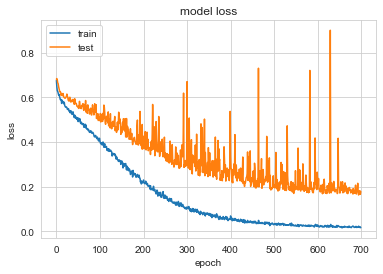

In [322]:
plt.plot(cnnhistory.history['loss'])
plt.plot(cnnhistory.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [323]:
# Saving the model.json

import json
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)

In [324]:
# loading json and creating model
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("model/aug_noiseNshift_2class2_np.h5")
print("Loaded model from disk")
 
# evaluate loaded model on test data
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(x_testcnn, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 94.70%


In [325]:
data_test = pd.DataFrame(columns=['feature'])
for i in tqdm(range(len(data3_df))):
    X, sample_rate = librosa.load(data3_df.path[i], res_type='kaiser_fast',duration=input_duration,sr=22050*2,offset=0.5)
#     X = X[10000:90000]
    sample_rate = np.array(sample_rate)
    mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
    feature = mfccs
    data_test.loc[i] = [feature]
    
test_valid = pd.DataFrame(data_test['feature'].values.tolist())
test_valid = np.array(test_valid)
test_valid_lb = np.array(data3_df.label)
lb = LabelEncoder()
test_valid_lb = np_utils.to_categorical(lb.fit_transform(test_valid_lb))
test_valid = np.expand_dims(test_valid, axis=2)

100%|██████████| 80/80 [00:06<00:00, 13.20it/s]


In [326]:
preds = loaded_model.predict(test_valid, 
                         batch_size=16, 
                         verbose=1)

5/5 [==============================] - 1s 70ms/step


In [327]:
preds

array([[6.8295248e-02, 9.3170482e-01],
       [1.6235779e-01, 8.3764219e-01],
       [2.1000397e-01, 7.8999597e-01],
       [9.4018001e-03, 9.9059814e-01],
       [2.9807368e-01, 7.0192635e-01],
       [5.2700429e-03, 9.9472988e-01],
       [8.8984603e-03, 9.9110150e-01],
       [6.9602118e-03, 9.9303973e-01],
       [3.7055197e-01, 6.2944806e-01],
       [2.7287519e-01, 7.2712481e-01],
       [7.7646083e-01, 2.2353916e-01],
       [2.0900686e-01, 7.9099315e-01],
       [2.4282606e-01, 7.5717390e-01],
       [2.4148490e-01, 7.5851506e-01],
       [9.3465507e-01, 6.5344870e-02],
       [1.3643791e-01, 8.6356211e-01],
       [1.8511578e-01, 8.1488425e-01],
       [6.6510242e-01, 3.3489764e-01],
       [1.1556718e-03, 9.9884427e-01],
       [2.6018361e-03, 9.9739814e-01],
       [1.6445975e-01, 8.3554029e-01],
       [3.8455646e-02, 9.6154433e-01],
       [5.0251083e-03, 9.9497485e-01],
       [4.4422641e-02, 9.5557743e-01],
       [1.4702508e-01, 8.5297489e-01],
       [1.5033266e-01, 8.

In [328]:
preds1=preds.argmax(axis=1)
preds1

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int64)

In [329]:
abc = preds1.astype(int).flatten()
predictions = (lb.inverse_transform((abc)))
preddf = pd.DataFrame({'predictedvalues': predictions})
preddf[:10]

,predictedvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [330]:
actual=test_valid_lb.argmax(axis=1)
abc123 = actual.astype(int).flatten()
actualvalues = (lb.inverse_transform((abc123)))
actualdf = pd.DataFrame({'actualvalues': actualvalues})
actualdf[:10]

,actualvalues
0,male_positive
1,male_positive
2,male_positive
3,male_positive
4,male_positive
5,male_positive
6,male_positive
7,male_positive
8,male_positive
9,male_positive


In [331]:
finaldf = actualdf.join(preddf)

In [332]:
finaldf[20:40]

,actualvalues,predictedvalues
20,male_negative,male_positive
21,male_negative,male_positive
22,male_negative,male_positive
23,male_negative,male_positive
24,male_negative,male_positive
25,male_negative,male_positive
26,male_negative,male_negative
27,male_negative,male_negative
28,male_negative,male_negative
29,male_negative,male_negative


In [333]:
finaldf.groupby('actualvalues').count()

,predictedvalues
actualvalues,
male_negative,48
male_positive,32


In [334]:
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
male_negative,41
male_positive,39


In [335]:
finaldf.to_csv('Predictions.csv', index=False)

In [336]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
from sklearn.metrics import accuracy_score
y_true = finaldf.actualvalues
y_pred = finaldf.predictedvalues
accuracy_score(y_true, y_pred)*100

66.25

In [337]:
from sklearn.metrics import f1_score
f1_score(y_true, y_pred, average='macro') *100

65.81737616711504

In [338]:
from sklearn.metrics import confusion_matrix
c = confusion_matrix(y_true, y_pred)
c

array([[31, 17],
       [10, 22]], dtype=int64)

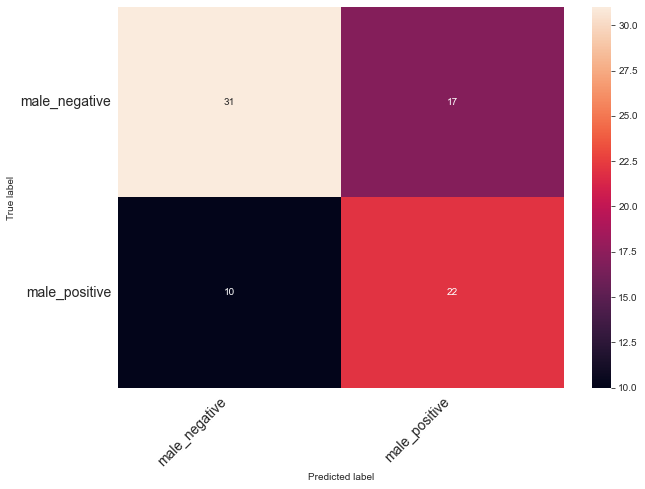

In [339]:
# Visualize Confusion Matrix 

# class_names = ['male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad']
# class_names = ['male_negative', 'male_neutral', 'male_positive']
class_names = ['male_negative', 'male_positive']
# class_names = ['female_angry', 'female_calm', 'female_fearful', 'female_happy', 'female_sad', 'male_angry', 'male_calm', 'male_fearful', 'male_happy', 'male_sad']


print_confusion_matrix(c, class_names)
